<a href="https://colab.research.google.com/github/vincentandaw/portfolio/blob/main/Python-Portfolio/PCA_and_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.datasets import load_breast_cancer
bcdat = load_breast_cancer()
X, y = bcdat.data, bcdat.target

random_state=14

In [2]:
### Preprocessing ###

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#we create train and test data, then carve out validation data from train
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=random_state)

sc = StandardScaler()
X_train = sc.fit_transform(X_train) #fit_transform for train; only fit_transform train
X_valid = sc.transform(X_valid) #transform uses the parameters (e.g. mean, variance) learned by train
X_test = sc.transform(X_test) #transform uses the parameters (e.g. mean, variance) learned by train

In [4]:
### Part 1a: PCA to get only five principal components ###

In [5]:
pca5 = PCA(n_components = 5) #Number of PCs we want = 5
X_train_pca = pca5.fit_transform(X_train) #Fit it to model
X_test_pca = pca5.transform(X_test) #Transform (do not fit) the X_test (to do predictions later)
X_valid_pca = pca5.transform(X_valid)

variance_explained = np.sum(pca5.explained_variance_ratio_)
variance_explained #0.999

0.8541446051615719

In [6]:
y_train.shape


(341,)

In [7]:
### Part 1b: Do prediction on these five components only. I will use a simple random forest ###

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

RF = RandomForestClassifier(max_depth=2, random_state=random_state)
RF.fit(X_train_pca,y_train)

y_pred = RF.predict(X_test_pca)
for_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(for_rmse) #0.2294

0.22941573387056177


In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RF, X_train_pca, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean()) #0.2464

0.27972711286174123


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[36  5]
 [ 1 72]]


In [11]:
### Part 2: Fit Neural Network to predict "Malignant" (0) or "Benign" (1)

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train_pca.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="softmax")(hidden2) #adding this layer 
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat) 
model = keras.models.Model(inputs=[input_], outputs=[output])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 40)           240         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           820         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 25)           0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [15]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = model.fit(X_train_pca, y_train, epochs=30,validation_data=(X_valid_pca, y_valid))

Epoch 1/30
11/11 [==============================] - 4s 103ms/step - loss: 9.7606 - accuracy: 0.2493 - val_loss: 7.9660 - val_accuracy: 0.3772
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 8.9511 - accuracy: 0.3079 - val_loss: 7.4097 - val_accuracy: 0.4035
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 8.3210 - accuracy: 0.3284 - val_loss: 6.7083 - val_accuracy: 0.4298
Epoch 4/30
11/11 [==============================] - 0s 20ms/step - loss: 8.1684 - accuracy: 0.3636 - val_loss: 6.4957 - val_accuracy: 0.4298
Epoch 5/30
11/11 [==============================] - 0s 22ms/step - loss: 7.3873 - accuracy: 0.4282 - val_loss: 5.2486 - val_accuracy: 0.5000
Epoch 6/30
11/11 [==============================] - 0s 15ms/step - loss: 6.6159 - accuracy: 0.4751 - val_loss: 4.4170 - val_accuracy: 0.5263
Epoch 7/30
11/11 [==============================] - 0s 10ms/step - loss: 5.3599 - accuracy: 0.5308 - val_loss: 3.5558 - val_accuracy: 0.6491
Epoch 8/30
11

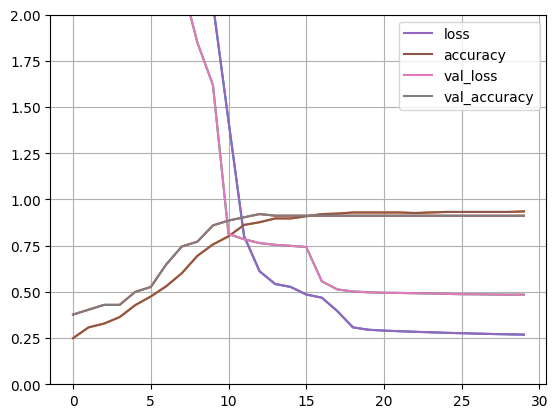

In [16]:
metrics = pd.DataFrame(history.history)
plt.plot(metrics)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [17]:
### Adding PCA created those val_loss spikes at epoch 12. Val_loss plateau also detected after epoch 15, but it does not flatline.

In [18]:
mse_test = model.evaluate(X_test_pca, y_test)
y_pred_NN = model.predict(X_test_pca)
print(y_pred_NN.min(),y_pred_NN.max())

4/4 [==============================] - 0s 6ms/step
-5.7111278 4.4934506


In [19]:
### Testing: No PCA ###

In [20]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="softmax")(hidden2)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat) 
model_noPCA = keras.models.Model(inputs=[input_], outputs=[output])

model_noPCA.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 40)           1240        ['input_2[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20)           820         ['dense_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 50)           0           ['input_2[0][0]',                
                                                                  'dense_5[0][0]']          

In [21]:
model_noPCA.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history_noPCA = model_noPCA.fit(X_train, y_train, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
11/11 [==============================] - 2s 45ms/step - loss: 2.7557 - accuracy: 0.7185 - val_loss: 2.6252 - val_accuracy: 0.7719
Epoch 2/30
11/11 [==============================] - 0s 8ms/step - loss: 2.5233 - accuracy: 0.7419 - val_loss: 2.5619 - val_accuracy: 0.7982
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 2.2066 - accuracy: 0.7537 - val_loss: 2.2423 - val_accuracy: 0.8070
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 2.1316 - accuracy: 0.7683 - val_loss: 2.0885 - val_accuracy: 0.8070
Epoch 5/30
11/11 [==============================] - 0s 26ms/step - loss: 2.0732 - accuracy: 0.7830 - val_loss: 1.9440 - val_accuracy: 0.8070
Epoch 6/30
11/11 [==============================] - 0s 16ms/step - loss: 2.0492 - accuracy: 0.7977 - val_loss: 1.9246 - val_accuracy: 0.8070
Epoch 7/30
11/11 [==============================] - 0s 9ms/step - loss: 2.0381 - accuracy: 0.8035 - val_loss: 1.9120 - val_accuracy: 0.8070
Epoch 8/30
11/11

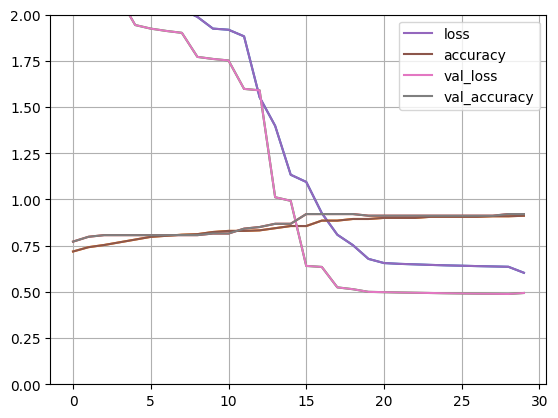

In [22]:
metrics_noPCA = pd.DataFrame(history_noPCA.history)
plt.plot(metrics_noPCA)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics_noPCA[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [23]:
### Saving ###
# save model in HDF5 format: architecture and hyperparameters, optimizer, starting state
model.save("my_keras_model.h5")

# load model
model = keras.models.load_model("my_keras_model.h5")

In [25]:
### Using early stopping and/or checkpoints ###

In [29]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) # Save only best checkpoint, overwriting previous best model

history = model.fit(X_train_pca, y_train, epochs=10,
                    validation_data=(X_valid_pca, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test_pca, y_test)

Epoch 1/10
11/11 [==============================] - 1s 44ms/step - loss: 0.2204 - val_loss: 0.1858
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.2075 - val_loss: 0.1763
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.1977 - val_loss: 0.1678
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.1879 - val_loss: 0.1609
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 0.1803 - val_loss: 0.1550
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.1734 - val_loss: 0.1498
Epoch 7/10
11/11 [==============================] - 0s 30ms/step - loss: 0.1673 - val_loss: 0.1457
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.1620 - val_loss: 0.1415
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.1574 - val_loss: 0.1381
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1542


In [30]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_pca, y_train, epochs=50,
                    validation_data=(X_valid_pca, y_valid),
                    callbacks=[checkpoint_cb,early_stopping_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test_pca, y_test)

#This will stop learning after 11 epochs

Epoch 1/50
11/11 [==============================] - 1s 29ms/step - loss: 0.1491 - val_loss: 0.1321
Epoch 2/50
11/11 [==============================] - 0s 14ms/step - loss: 0.1460 - val_loss: 0.1296
Epoch 3/50
11/11 [==============================] - 0s 12ms/step - loss: 0.1428 - val_loss: 0.1272
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.1255
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 0.1379 - val_loss: 0.1234
Epoch 6/50
11/11 [==============================] - 0s 11ms/step - loss: 0.1354 - val_loss: 0.1216
Epoch 7/50
11/11 [==============================] - 0s 12ms/step - loss: 0.1333 - val_loss: 0.1199
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.1318 - val_loss: 0.1184
Epoch 9/50
11/11 [==============================] - 0s 15ms/step - loss: 0.1296 - val_loss: 0.1172
Epoch 10/50
11/11 [==============================] - 0s 12ms/step - loss: 0.1281 - val_loss: 0.1159
Epoch 11/